<a href="https://colab.research.google.com/github/mille055/AIPI590-XAI/blob/main/Assignments/04_Interpretable_AI_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# AIPI 590 - XAI | Assignment 03

#Description: Interpretable AI
This notebook is for exploring interpretable models using imodels (https://github.com/csinva/imodels?tab=readme-ov-file). Imodels is a Python package containing models for concise, transparent, and accurate predictive modeling. The dataset being explored is:

## Chad Miller

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mille055/AIPI590-XAI/blob/main/Assignments/04_Interpretable_AI_part2.ipynb)

Acknowledgements: Class Repository code on GAM model, kaggle telco-customer-churn dataset

In [1]:
import os

# Remove Colab default sample_data
!rm -r /content/sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI590-XAI"
git_path = 'https://github.com/mille055/AIPI590-XAI.git'
!git clone "{git_path}"

# Install dependencies from requirements.txt file
!pip install -r "{os.path.join(repo_name,'requirements.txt')}"


notebook_dir = 'Assignments'
path_to_notebook = os.path.join(repo_name,notebook_dir)


Cloning into 'AIPI590-XAI'...
remote: Enumerating objects: 230, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 230 (delta 23), reused 0 (delta 0), pack-reused 191 (from 1)
Receiving objects: 100% (230/230), 26.82 MiB | 24.65 MiB/s, done.
Resolving deltas: 100% (139/139), done.
  Cloning https://github.com/christophM/rulefit.git to /tmp/pip-install-x4dnsf0d/rulefit_c44c1da79bc14d38aea437e0dc4a062f
  Running command git clone --filter=blob:none --quiet https://github.com/christophM/rulefit.git /tmp/pip-install-x4dnsf0d/rulefit_c44c1da79bc14d38aea437e0dc4a062f
  Resolved https://github.com/christophM/rulefit.git to commit 472b8574b4eb9e565caf1e05ed580998fe2c9a8e
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 28.4 MB

In [2]:
## Standard libraries
import json
import math
import time
import numpy as np
import tabulate
import urllib.request
import zipfile
import pandas as pd

## Imports for data exploration
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

## Imports for linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report


## Imports for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

## Imports for imodels assignment
from sklearn.datasets import load_diabetes, load_breast_cancer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, export_text

## Imports for GAM
from pygam import LogisticGAM, LinearGAM, GammaGAM, s

## Imports for imodels
from imodels import get_clean_dataset
from imodels import SLIMClassifier, OneRClassifier, BoostedRulesClassifier, FIGSClassifier, HSTreeClassifierCV
from imodels import SLIMRegressor, BayesianRuleListClassifier, RuleFitRegressor,RuleFitClassifier, GreedyRuleListClassifier
from imodels.discretization import ExtraBasicDiscretizer

## Imports for plotting
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms, datasets
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import ImageNet




In [3]:
# Get secrets if necessary
# from google.colab import userdata
# userdata.get('secretName')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Get device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print('device is ', device)

device is  cuda:0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# Downloading dataset
data = load_breast_cancer(as_frame=True)
df = data.frame
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## Exploratory Data Analysis

Dataset:


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Shape: (569, 31)
Columns: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension', 'target']
Missing Values: 0
Data Types: {dtype('float64'): 30, dtype('int64'): 1}
Unique Values: {'mean radius': 456, 'mean texture': 479, 'mean perimeter': 522, 'mean area': 539, 'mean smoothness': 474, 'mean compactness': 537, 'mean concavity': 537, 'mean concave points': 542, 'mean symmetry': 432, 'mean fractal dimension': 499, 'radius error': 540, 'texture error': 519, 'perimeter error': 533

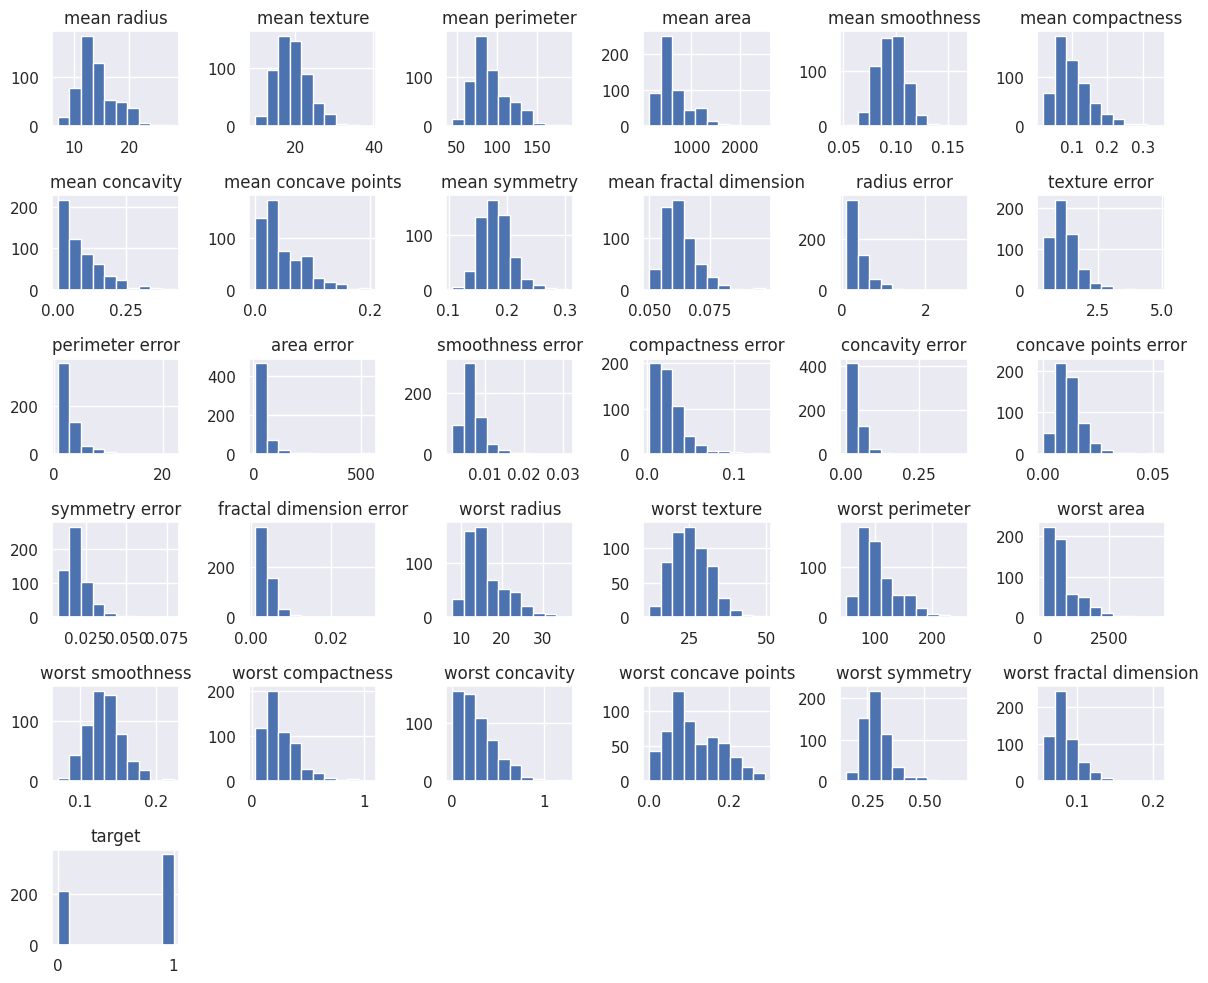

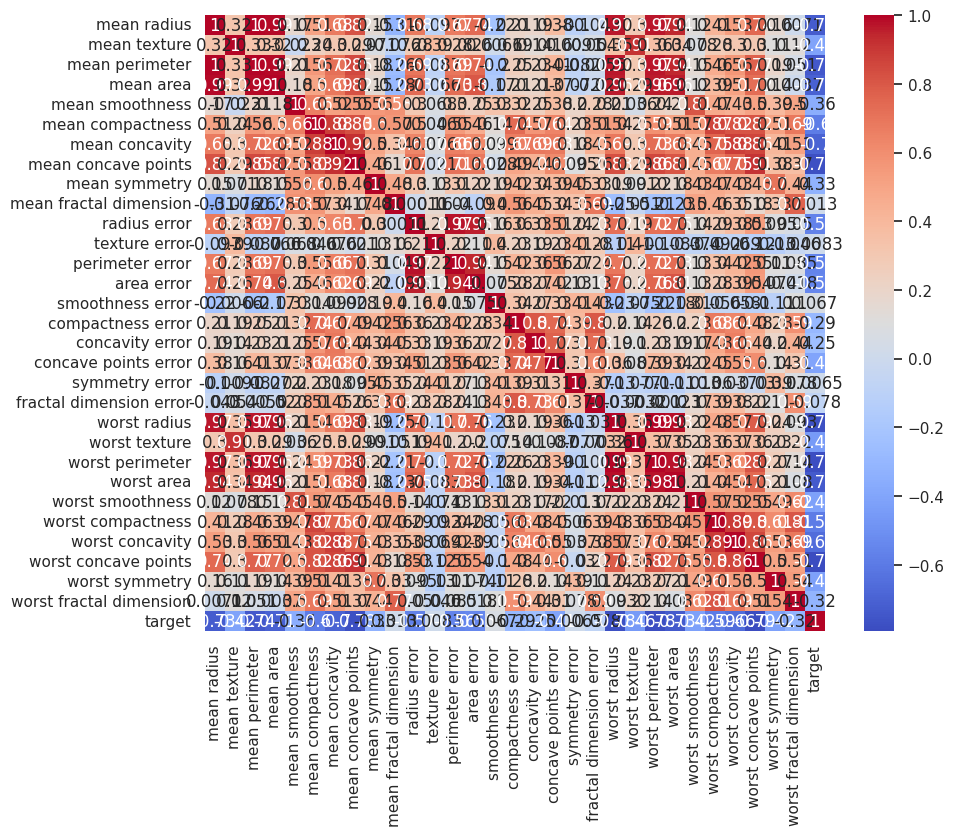


Colinearity Check:

                    Feature          VIF
0                     const  2041.278511
1               mean radius  3817.259795
2              mean texture    11.891280
3            mean perimeter  3792.697001
4                 mean area   348.115385
5           mean smoothness     8.194309
6          mean compactness    51.445960
7            mean concavity    71.002747
8       mean concave points    60.172431
9             mean symmetry     4.220806
10   mean fractal dimension    15.756978
11             radius error    75.737325
12            texture error     4.205686
13          perimeter error    70.398925
14               area error    41.196467
15         smoothness error     4.070801
16        compactness error    15.366350
17          concavity error    15.914022
18     concave points error    11.601253
19           symmetry error     5.179151
20  fractal dimension error     9.724753
21             worst radius   815.945630
22            worst texture    18.60

In [6]:
# Check multicollinearity using Variance Inflation Factor (VIF)
def check_multicollinearity(df):
  X = df.select_dtypes(include=[float, int])  # Select only numeric features

  # Add constant for the intercept term
  X = sm.add_constant(X)

  # Calculate VIF
  vif_data = pd.DataFrame()
  vif_data['Feature'] = X.columns
  vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

  print(vif_data)


def EDA(df):
  df1= df.copy()

  # Display basic information about the dataset
  dataset_info = {
    'Shape': df1.shape,
    'Columns': df1.columns.tolist(),
    'Missing Values': df1.isnull().sum().sum(),
    'Data Types': df1.dtypes.value_counts().to_dict(),
    'Unique Values': df1.nunique().to_dict()
  }

  for key, value in dataset_info.items():
    print(f"{key}: {value}")


  print(df1.head())

  # Summary statistics
  summary_statistics = df1.describe()
  print(summary_statistics)

  # Visualize numerical features
  df1.hist(figsize=(12,10))
  plt.tight_layout()
  plt.show()

  # Correlation matrix for numerical features after dropping any non-numeric columns

  df1_numeric = df1.select_dtypes(include=['float64', 'int64'])
  corr_matrix = df1_numeric.corr()
  plt.figure(figsize=(10, 8))
  sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
  plt.show()


  # # Pairplot - but takes awhile so only doing the first time
  # print('\nPairplot:\n')
  # sns.pairplot(df1)
  # plt.show()

  # Check colinearity
  print('\nColinearity Check:\n')
  check_multicollinearity(df1)


EDA(df)

## Learned from the EDA:
There are several points to take away from the EDA, including:

1. There are 569 examples with no missing values.

2. Average, median, and std dev valus of the features are given above.

3. Features like mean radius (3817.26), mean perimeter (3792.70), worst radius (815.95), and worst perimeter (405.15) have extremely high VIFs, indicating that they are highly collinear with other features.

## Prepare training and testing datasets

In [7]:
# Preparation of the train/test datasets

X = df.drop(columns=['target'])
y = df['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Rulefit

In [8]:
# Train RuleFit model
rulefit_model = RuleFitClassifier(random_state=42)
rulefit_model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = rulefit_model.predict(X_test_scaled)
print(f'Accuracy of RuleFit: {accuracy_score(y_test, y_pred):.2f}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy of RuleFit: 0.96


In [9]:
rule_df = rulefit_model.visualize()
rule_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,rule,coef
15,X15,0.14
19,X19,0.18
24,X24,-0.19
45,X21 <= 1.30523 and X27 <= 0.5785,1.46
50,X20 <= 0.26132 and X27 <= 0.74306,0.32
44,X10 <= 0.49506 and X14 > -1.31762 and X27 <= 0.51267,0.77
43,X23 <= -0.01228 and X27 <= 0.69369,0.08
47,X10 <= 0.76102 and X22 <= 0.2417 and X27 <= 0.52051,0.92
53,X13 <= -0.07757 and X7 <= 0.21029,0.13
51,X22 <= -0.11089,-0.51


Repeating rulefit using a dataset with reduced number of features based on multicolinearity.



In [10]:
## removing some of the colinear features
# List of features to remove based on prior analysis
features_to_remove = [
    'mean perimeter', 'mean area', 'perimeter error', 'area error',
    'mean compactness', 'mean concave points', 'worst compactness', 'worst concave points',
    'mean symmetry', 'symmetry error', 'worst symmetry',
    'mean fractal dimension', 'worst fractal dimension', 'fractal dimension error'
]

# reducing to 16 features

df_reduced = df.drop(columns=features_to_remove)
print(df_reduced.shape)
print(df_reduced.head())

X_reduced = df_reduced.drop(columns=['target'])
y = df_reduced['target']

# splitting the dataset into train/test
X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)


(569, 17)
   mean radius  mean texture  mean smoothness  mean concavity  radius error  \
0        17.99         10.38          0.11840          0.3001        1.0950   
1        20.57         17.77          0.08474          0.0869        0.5435   
2        19.69         21.25          0.10960          0.1974        0.7456   
3        11.42         20.38          0.14250          0.2414        0.4956   
4        20.29         14.34          0.10030          0.1980        0.7572   

   texture error  smoothness error  compactness error  concavity error  \
0         0.9053          0.006399            0.04904          0.05373   
1         0.7339          0.005225            0.01308          0.01860   
2         0.7869          0.006150            0.04006          0.03832   
3         1.1560          0.009110            0.07458          0.05661   
4         0.7813          0.011490            0.02461          0.05688   

   concave points error  worst radius  worst texture  worst perimeter 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# Train RuleFit model on the reduced dataset
rulefit_reduced_model = RuleFitClassifier(random_state=42)
rulefit_reduced_model.fit(X_train_reduced_scaled, y_train)

# Evaluate
y_pred = rulefit_reduced_model.predict(X_test_reduced_scaled)
print(f'Accuracy of RuleFit: {accuracy_score(y_test, y_pred):.2f}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy of RuleFit: 0.98


In [12]:
rule_reduced_df = rulefit_reduced_model.visualize()
rule_reduced_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,rule,coef
2,X2,-0.21
4,X4,-0.00
7,X7,0.03
11,X11,-0.20
26,X3 <= 0.27437 and X4 <= 0.76102,0.09
35,X10 <= 0.10695 and X12 <= 0.31888 and X14 <= 2.02129 and X4 <= 2.11819,0.78
28,X1 <= 0.74982 and X12 <= 0.30526,0.00
29,X12 <= 0.30526 and X3 <= 0.20041 and X4 <= 0.53781,1.50
38,X12 <= 0.45053 and X3 <= 0.2107 and X6 > -1.18,0.14
34,X13 <= -0.01228 and X15 <= 0.69912,0.06


A few points about rulefit for the reduced breast cancer dataset:

1. The accuracy was high of 0.98 (compared with 0.96 for the original dataset containing all features).
2. For the rules produced by the rulefit model:

Individual Features (Linear Terms)

*   X2 (mean texture) with a coefficient of -0.21: This means that higher values of mean texture are associated with a decrease in the target value (indicating benign characteristics if the target is malignancy).
*   X11 (worst radius) with a coefficient of -0.20: Similarly, a larger worst radius slightly reduces the predicted outcome.

Decision rules with multiple features
* X12 <= 0.30526 and X3 <= 0.20041 and X4 <= 0.53781 has a coefficient of 1.50:
This is the highest positive coefficient, meaning it's a significant predictor of a higher target outcome when all these conditions are true:
worst perimeter ≤ 0.30526
mean smoothness ≤ 0.20041
mean concavity ≤ 0.53781
This rule significantly influences the model's decision, suggesting it’s a combination suggestive of malignancy.


* X10 <= 0.10695 and X12 <= 0.31888 and X14 <= 2.02129 and X4 <= 2.11819 has a positive coefficient of 0.78, indicating it has a strong effect when these conditions hold true:
X10 (concave points error) <= 0.10695
X12 (worst perimeter) <= 0.31888
X14 (worst smoothness) <= 2.02129
X4 (mean concavity) <= 2.11819

* X11 > -0.93104 and X12 > -0.16385 and X15 > -0.35809 has a coefficient of -1.18, which is a high negative coefficient. When these conditions are met:
worst radius is higher than threshold,
worst perimeter is higher than threhsold,
worst concavity is greater than threshold. These findings suggest benign characteristics.






## Visualizations of rulefit

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


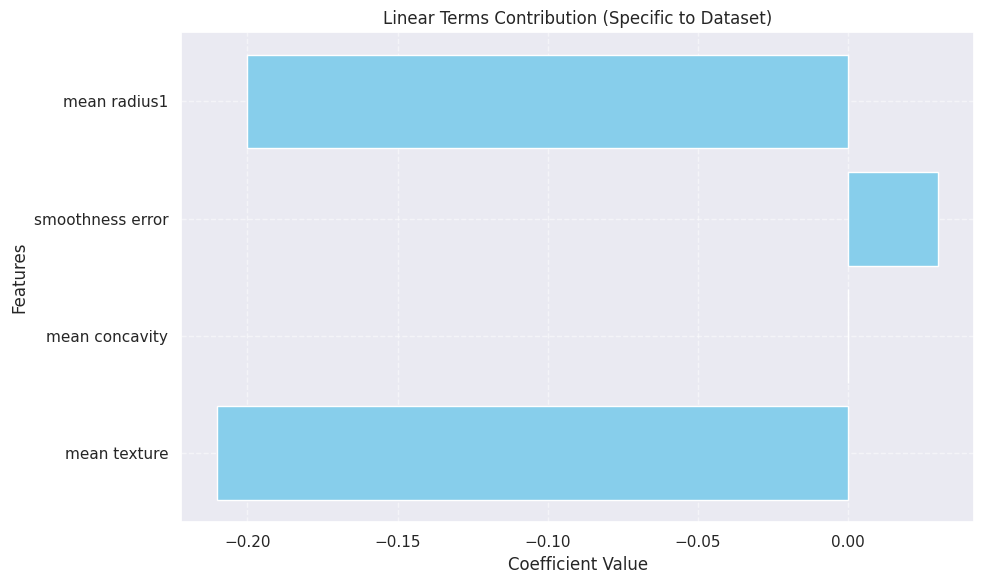

<ipython-input-13-928e7147dd61>:58: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


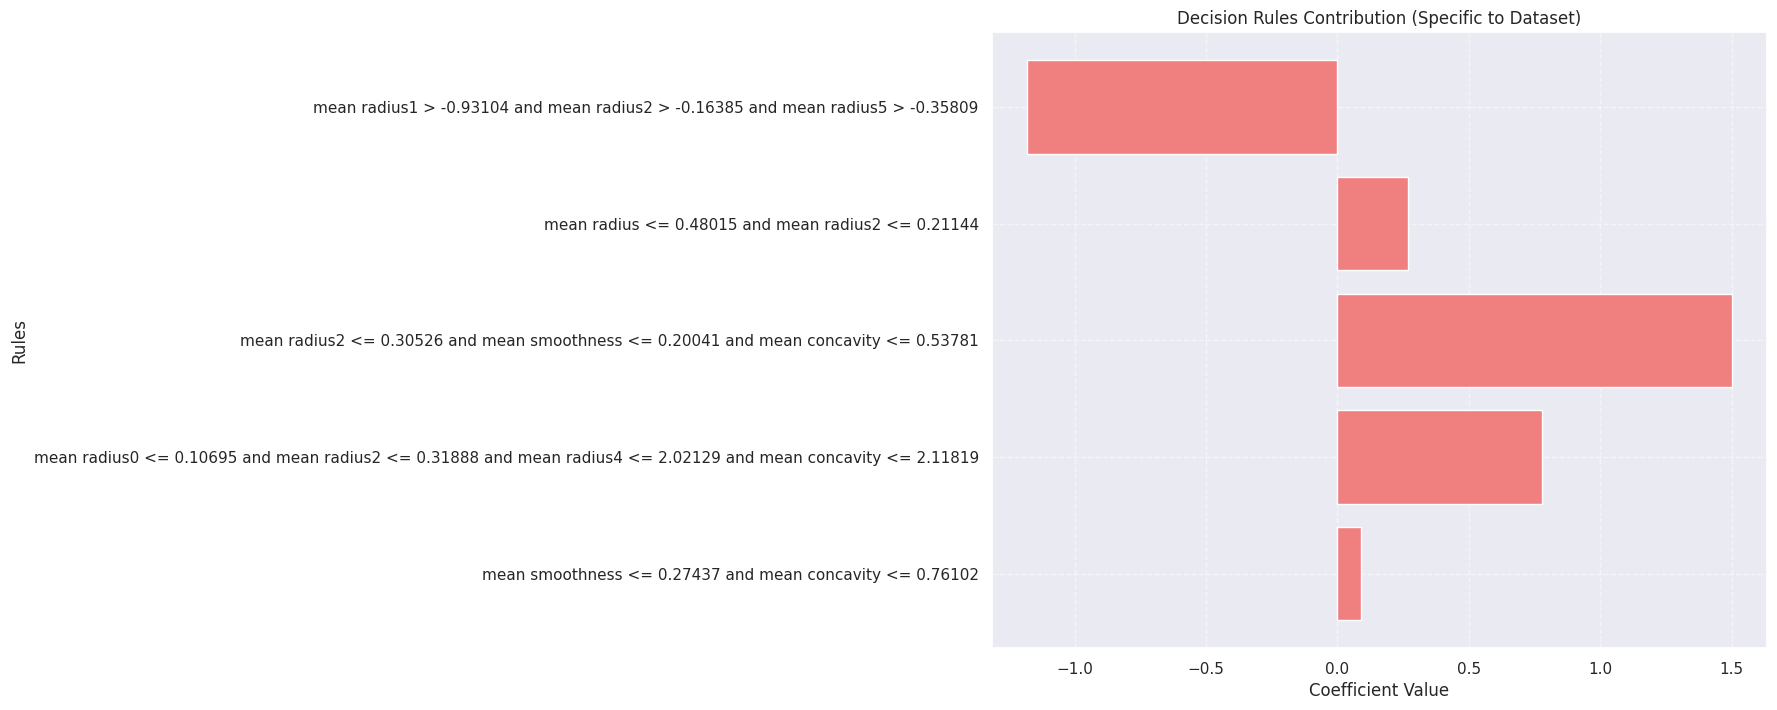

In [13]:

# Given rules and coefficients from your RuleFit model
rules_data = {
    'X3 <= 0.27437 and X4 <= 0.76102': 0.09,
    'X10 <= 0.10695 and X12 <= 0.31888 and X14 <= 2.02129 and X4 <= 2.11819': 0.78,
    'X12 <= 0.30526 and X3 <= 0.20041 and X4 <= 0.53781': 1.50,
    'X1 <= 0.48015 and X12 <= 0.21144': 0.27,
    'X11 > -0.93104 and X12 > -0.16385 and X15 > -0.35809': -1.18,
    'X2': -0.21,
    'X4': -0.00,
    'X7': 0.03,
    'X11': -0.20
}

# Map the feature indices to their actual names
feature_mapping = {
    'X1': 'mean radius',
    'X2': 'mean texture',
    'X3': 'mean smoothness',
    'X4': 'mean concavity',
    'X7': 'smoothness error',
    'X10': 'concave points error',
    'X11': 'worst radius',
    'X12': 'worst texture',
    'X14': 'worst smoothness',
    'X15': 'worst concavity'
}

# rules and feature names to be more interpretable

interpreted_rules = {}
for rule, coef in rules_data.items():
    interpreted_rule = rule
    for old, new in feature_mapping.items():
        interpreted_rule = interpreted_rule.replace(old, new)
    interpreted_rules[interpreted_rule] = coef

# Separate out the linear terms and rules
linear_terms = {k: v for k, v in interpreted_rules.items() if not ('and' in k)}
rules_only = {k: v for k, v in interpreted_rules.items() if 'and' in k}

# Plot linear terms
plt.figure(figsize=(10, 6))
plt.barh(list(linear_terms.keys()), list(linear_terms.values()), color='skyblue')
plt.title('Linear Terms Contribution (Specific to Dataset)')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot rules contribution
plt.figure(figsize=(10, 8))
plt.barh(list(rules_only.keys()), list(rules_only.values()), color='lightcoral')
plt.title('Decision Rules Contribution (Specific to Dataset)')
plt.xlabel('Coefficient Value')
plt.ylabel('Rules')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


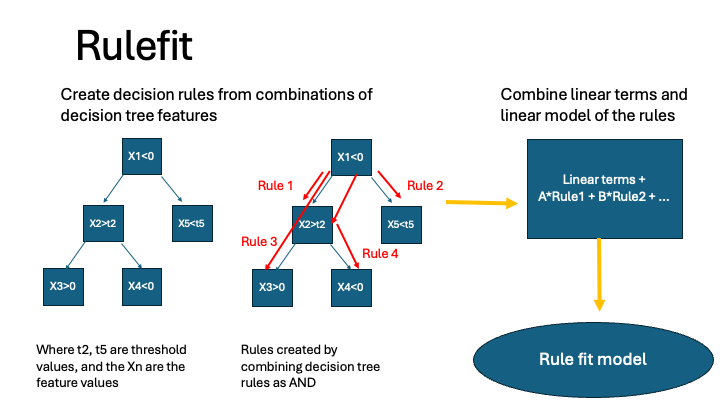

In [14]:
rulefit_image_path = os.path.join('AIPI590-XAI', 'Assignments', 'Visualizations', 'rulefit.png')
Image(filename=rulefit_image_path)


## Boosted Rules Classifier (BRC)

The BoostedRulesClassifier is an interpretable machine learning model that combines the power of rule-based models with boosting techniques to create a model that is both accurate and understandable. It is in the family of ensemble models, specifically designed to handle complex datasets while maintaining transparency in its decision-making process.

The model starts by generating a set of simple decision rules from the features of the dataset. These rules are like "if-then" statements, e.g., "if mean radius > 15 and mean texture < 20, then predict malignant."
Each rule is created using decision tree splits. The boosting is an iterative process where the model learns from its mistakes. Initially, the model creates a simple rule and makes predictions, and refines this based on the early predictions.

In [15]:
brc_model = BoostedRulesClassifier(random_state=42)
brc_model.fit(X_train_reduced_scaled, y_train)

# Make predictions
y_pred = brc_model.predict(X_test_reduced_scaled)

# Assess model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of BoostedRulesClassifier: {accuracy:.2f}')

# Detailed classification report
print(classification_report(y_test, y_pred))



Accuracy of BoostedRulesClassifier: 0.98
              precision    recall  f1-score   support

           0       0.98      0.95      0.97        63
           1       0.97      0.99      0.98       108

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of base estimators (trees): 15
Rules from tree 1:

|--- worst perimeter <= 0.21
|   |--- class: 1.0
|--- worst perimeter >  0.21
|   |--- class: 0.0



Rules from tree 2:

|--- mean concavity <= -0.18
|   |--- class: 1.0
|--- mean concavity >  -0.18
|   |--- class: 0.0



Rules from tree 3:

|--- mean texture <= 0.39
|   |--- class: 1.0
|--- mean texture >  0.39
|   |--- class: 0.0



Rules from tree 4:

|--- worst radius <= -0.64
|   |--- class: 1.0
|--- worst radius >  -0.64
|   |--- class: 0.0



Rules from tree 5:

|--- mean smoothness <= -0.48
|   |--- class: 1.0
|--- mean smoothness >  -0.48
|   |--- class: 0.0





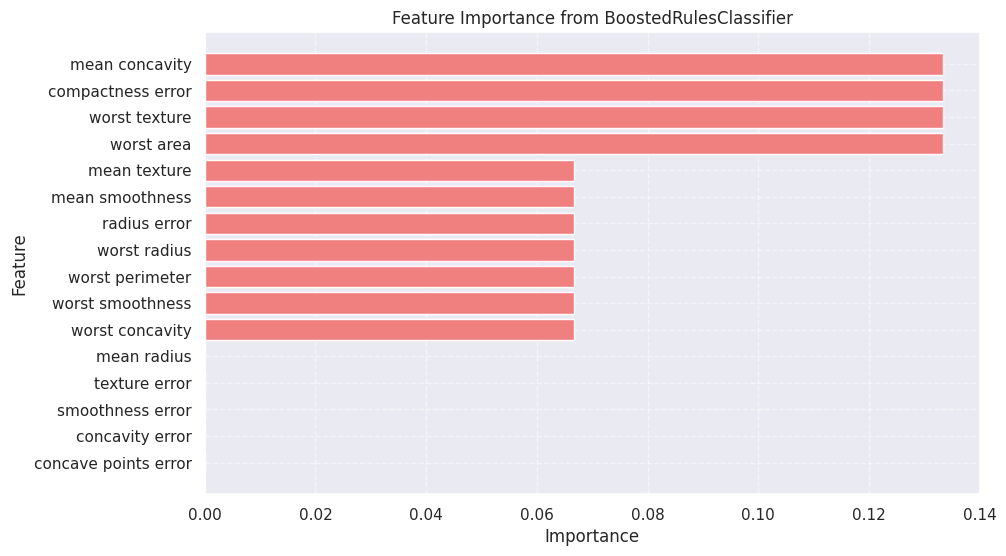

In [16]:
# Extract the rules from the BoostedRulesClassifier
# Access the individual base estimators (decision trees) from the BoostedRulesClassifier
base_estimators = brc_model.estimators_

# Check how many base estimators (rules) are present
print(f"Number of base estimators (trees): {len(base_estimators)}")

# Extract text
for i, estimator in enumerate(base_estimators[:5]):  # Extract rules from the first 5 trees
    print(f"Rules from tree {i + 1}:\n")
    print(export_text(estimator, feature_names=X_reduced.columns.tolist()))
    print("\n" + "=" * 50 + "\n")


# Access feature importances from the BoostedRulesClassifier
feature_importances = brc_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_reduced.columns,
    'Importance': feature_importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='lightcoral')
plt.title('Feature Importance from BoostedRulesClassifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


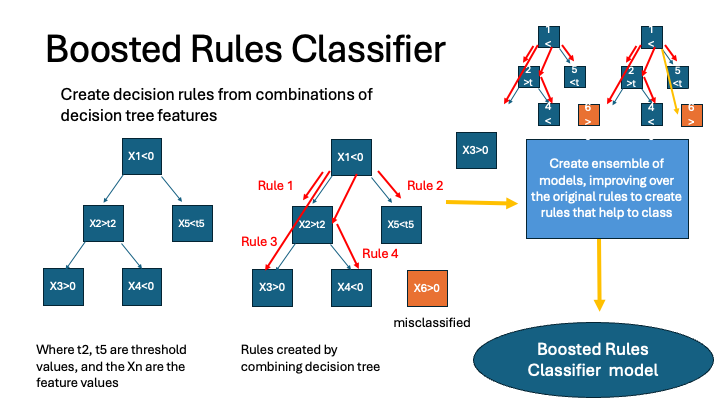

In [17]:
## visualize schematic of Boosted Rules Classifier

brc_image_path = os.path.join('AIPI590-XAI', 'Assignments', 'Visualizations', 'brc.png')
Image(filename=brc_image_path)

## SLIM (Supersparse Linear Integer Model)
SLIM is an interpretable machine learning model that aims to create a linear model with integer coefficients. The model generates sparse models (many coefficients are zero), meaning it selects only a few important features, and uses integer weights (e.g., -2, 1, 3), making it very easy to understand. The model balances accuracy and interpretability by being both sparse and using simple, integer-based coefficients. While SLIM can be computationally intensive for larger datasets or datasets with many features because it searches for the optimal sparse model, this isn't a significant issue for the Breast Cancer dataset.

As stated in the paper [1], the model comprises a scoring system which, "are linear classification models that only require users to add, subtract and multiply a few small numbers in order to make a prediction. These models are used to assess the risk of numerous serious medical conditions since they allow physicians to make quick predictions, without extensive training, and without the use of a computer." [1] https://arxiv.org/pdf/1502.04269

In [18]:
# Initialize and fit the SLIM model
slim_model = SLIMClassifier()
slim_model.fit(X_train_reduced_scaled, y_train)

# Make predictions
y_pred = slim_model.predict(X_test_reduced_scaled)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/imodels/algebraic/slim.py:144: UserWarning: mosek solver required for mixed-integer exponential cone programming. Rounding non-integer coefficients instead
  warnings.warn("mosek solver required for mixed-integer exponential cone "


In [19]:
# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of SLIM: {accuracy:.2f}')

# Detailed classification report
print(classification_report(y_test, y_pred))

# Access the internal model from slim_model
internal_model = slim_model.model_

# Extract the coefficients
coefficients = internal_model.coef_
print("SLIM Model Coefficients:", coefficients)

Accuracy of SLIM: 0.98
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        63
           1       0.98      0.98      0.98       108

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171

SLIM Model Coefficients: [[-1  0  0 -1 -2  0  0  1  1 -1 -1 -2 -1 -1 -1 -1]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
# Access the internal model from slim_model
internal_model = slim_model.model_

# Extract the coefficients
coefficients = internal_model.coef_
print("SLIM Model Coefficients:", coefficients)

SLIM Model Coefficients: [[-1  0  0 -1 -2  0  0  1  1 -1 -1 -2 -1 -1 -1 -1]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
coef_list = zip(X_reduced.columns, coefficients[0])
coef_df = pd.DataFrame(coef_list, columns=['Feature', 'Coefficient'])
coef_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Feature,Coefficient
0,mean radius,-1
1,mean texture,0
2,mean smoothness,0
3,mean concavity,-1
4,radius error,-2
5,texture error,0
6,smoothness error,0
7,compactness error,1
8,concavity error,1
9,concave points error,-1


The models have similar accuracy in predicting malignancy (98%). The relative importance of certain features differs (in terms of feature-importance or their coefficients in a linear model) are somewhat different among the three models.

With regards to Interpretability:
* **SLIM Model:**
The SLIM model provides high interpretability because it uses sparse linear equations with integer coefficients. Each feature's contribution is easily understandable, making it clear how predictions are made. The integer coefficients indicate the weight or impact of each feature on the prediction, which is ideal for explaining model behavior to non-experts. The model's sparsity means that only a few features are selected, making it easier to identify the most important factors influencing the prediction but possibly limiting accuracy (although not in the case of this dataset).

* **Boosted Rules Classifier and RuleFit:**
The Boosted Rules Classifier is also interpretable but combines multiple rules in an ensemble format, which can make it slightly harder to interpret compared to SLIM’s linear equation. It can possibly capture more complex relaitonships.

  RuleFit provides linear terms and decision rules, offering a good balance between accuracy and interpretability, but it is more complex than SLIM’s integer-based linear model. RuleFit captures feature importance through both linear terms and rules but may include more features, making it less sparse compared to SLIM.